In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import helper.helper as h
import statsmodels.api as sm
from tqdm import tqdm

In [2]:
def ols_W(X, P):
    # translate X
    x = X @ P.T

    # get regressor and varibles
    y = x[1:]
    x = x[:-1]

    W_hat = np.array(np.zeros(p)).T

    # get parameters
    for i in range(p):
        est = sm.OLS(y[:, i], x[:, :(i + 1)]).fit()   
        W_hat = np.vstack((W_hat, np.append(est.params, np.zeros(p - (i + 1))).T))

    return P.T @ W_hat[1:].T @ P

In [3]:
def generate_U(p, num_edges, low = 0.5, high = 2.0, tril = False):
    edges = np.array([0.0] * (int(p * (p + 1) / 2) - num_edges - p * tril) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(low, high, num_edges)
    np.random.shuffle(edges)
    
    U = np.zeros((p, p))
    
    U[np.tril_indices(p, - tril)] = edges
    
    return U

U:
[[ 0.5   0.   -1.27  0.   -1.64]
 [ 0.    0.5   0.   -0.71  1.  ]
 [ 0.    0.    0.5   0.    1.32]
 [ 0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.5 ]]

P:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]].
[[ 0.5         0.          0.          0.          0.        ]
 [ 1.32079288  0.5         0.          0.          0.        ]
 [-1.64091342 -1.27248615  0.5         0.          0.        ]
 [ 0.          0.          0.          0.5         0.        ]
 [ 1.00429605  0.          0.         -0.71424249  0.5       ]]
[[ 0.53780564  0.          0.          0.          0.        ]
 [ 1.31218174  0.42447028  0.          0.03734839  0.        ]
 [-1.52030304 -1.21720458  0.50915046  0.09108211  0.08690606]
 [ 0.27721171  0.          0.          0.43907051  0.        ]
 [ 1.22145096 -0.01968675  0.         -0.73484516  0.71472589]]


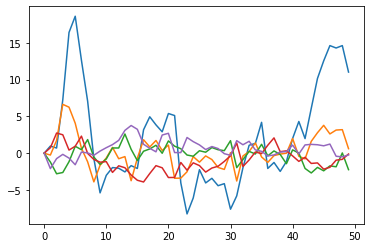

In [4]:
## Number of dimensions, number of edges, number of samples
T, p, s = 50, 5, 5

## Coefficient matrix
U_true = generate_U(p, s, tril = True).T
for i in range(p):
    U_true[i][i] = 0.5

## True permutation
P_true = np.random.permutation(np.identity(p))

## Generate series
X = h.generate_var_2(T, p, U_true, P_true)
plt.plot(X);

print(f"U:\n{np.round(U_true, 2)}\n\nP:\n{P_true}.")

print(P_true.T @ U_true @ P_true)

print(ols_W(X, P_true))

In [5]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()
    
    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)
    
    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]
    
    # return new sample
    return P_return

In [6]:
def loss(W, X):
    return 1 / (T - 1) * np.linalg.norm(X[1:] - X[:-1] @ W, 'f') ** 2

def get_likelihood(P):
    # get optimal A for this permutation
    W_opt = ols_W(X, P)

    # get loss    
    return loss(W_opt, X)

print(ols_W(X, P_true))
O = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:]
min_likelihood = loss(O, X)
print(loss(ols_W(X, P_true), X))

[[ 0.53780564  0.          0.          0.          0.        ]
 [ 1.31218174  0.42447028  0.          0.03734839  0.        ]
 [-1.52030304 -1.21720458  0.50915046  0.09108211  0.08690606]
 [ 0.27721171  0.          0.          0.43907051  0.        ]
 [ 1.22145096 -0.01968675  0.         -0.73484516  0.71472589]]
4.582342771885209


In [9]:
L_ols = loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
k = 2

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols = L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k = k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k = k, L_ols = L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new, k = k, L_ols = L_ols):
    return L_new < L

def mcmc(max_it, verbose = False, P = np.identity(p), factor = 1.0, acc_prob = acc_prob_reg):
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = get_likelihood(P) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = get_likelihood(P_prime)
        alpha = acc_prob(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ U_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(transitions)
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

def rw_1(max_it, verbose = False, P = np.identity(p), factor = 1.0):
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    num_missed_edges = []
    for i in tqdm(range(max_it)):   
        # sample next P
        P = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P = get_likelihood(P)
        
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
                
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ U_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, num_missed_edges]

def rw_2(max_it, verbose = False, P = np.identity(p), factor = 1.0):
    # initial value
    likelihood_P = get_likelihood(P)

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    num_missed_edges = []
    for i in tqdm(range(max_it)):   
        # sample next P
        P = np.random.permutation(P)
    
        # compute acceptance probability
        likelihood_P = get_likelihood(P)
        
        # save best
        if likelihood_P < L_best:
            L_best = likelihood_P
            P_best = P
                
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        check_triu = np.triu(P_best @ P_true.T @ U_true @ P_true @ P_best.T)
        num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")
    return P_best, [results_l_iter, results_likelihood, num_missed_edges]

35


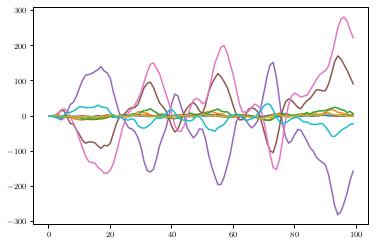

In [71]:
np.random.seed(seed = 1)

## Number of dimensions, number of edges, number of samples
T, p, s = 100, 10, 25

## Coefficient matrix
U_true = generate_U(p, s, tril = True).T
for i in range(p):
    U_true[i][i] = 0.5

## True permutation
P_true = np.random.permutation(np.identity(p))

W = P_true.T @ U_true @ P_true

print((W != 0).sum())
## Generate series
X = h.generate_var_2(T, p, U_true, P_true)
plt.plot(X);

In [18]:
np.random.seed(seed = 3)
rwP, rw_l = rw_1(360, False)
np.random.seed(seed = 4)
P, r = mcmc(360, False, acc_prob = acc_prob_reg)

  3%|██▋                                                                             | 12/360 [00:00<00:03, 112.15it/s]

Best permutation:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Likelihood: 26.03.


100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:03<00:00, 101.45it/s]

265
Best permutation:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

Likelihood: 13.02.


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


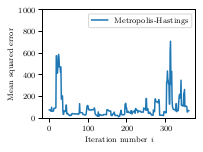

In [27]:
fig = plt.figure(figsize = (2.75, 2.0))
plt.ylim(-5, 1000)
plt.xlabel("Iteration number $i$")
plt.ylabel("Mean squared error")
plt.plot(np.array(r[0]), label = "Metropolis-Hastings")
# plt.plot(np.array(rw_l[0]), label = "Random Walk")
plt.legend()
plt.savefig('MCMC_Ex1_plot_MCMC_v1.pgf')
plt.show()

# fig = plt.figure(figsize = (5.5, 3))
# #plt.ylim(-5, 95)
# plt.xlabel("Iteration number")
# plt.ylabel("Likelihood")
# plt.plot(np.array(rw_l[0]), label = "Metropolis-Hastings")
# # plt.plot(np.array(rw_l[0]), label = "Random Walk")
# plt.legend()
# # plt.savefig('MCMC_Ex2_plot_MCMC.pgf')

Suitable permutation found: False.
30 out of 35 edges recovered.


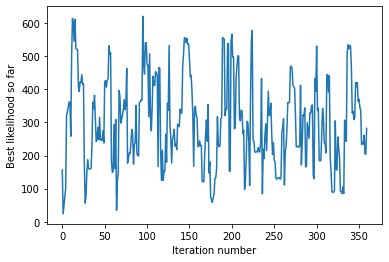

In [95]:
# verify whether the permutation is campatible
check = P @ P_true.T @ U_true @ P_true @ P.T
check_triu = np.triu(check)
print(f"Suitable permutation found: {len(check_triu[check_triu != 0]) == s + p}.")
print(f"{len(check_triu[check_triu != 0])} out of {s + p} edges recovered.")
plt.xlabel("Iteration number")
plt.ylabel("Best likelihood so far")
plt.plot(np.array(rw_l[0]))
# plt.plot(rw_l_list)

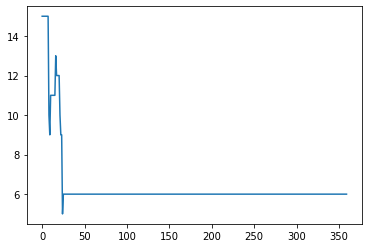

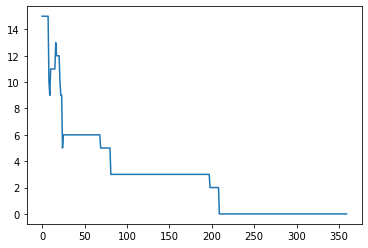

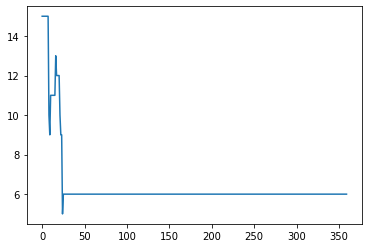

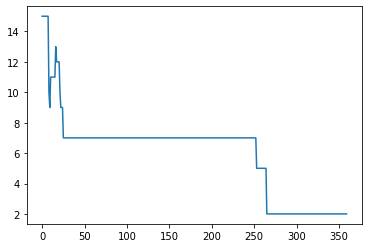

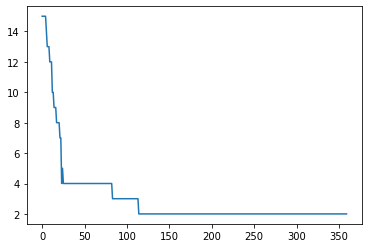

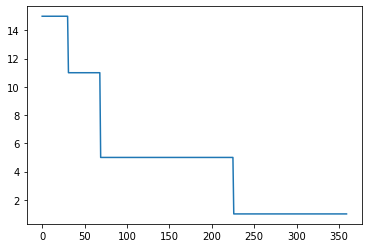

In [61]:
plt.plot(p + s - np.array(r[-1]))
plt.show()
plt.plot(p + s - np.array(rp[-1]))
plt.show()
plt.plot(p + s - np.array(rt[-1]))
plt.show()
plt.plot(p + s - np.array(rtp[-1]))
plt.show()
plt.plot(p + s - np.array(rg[-1]))
plt.show()
plt.plot(p + s - np.array(rw_l[-1]))

In [31]:
print("Regular MCMC")
print(np.mean(np.array(r[0])))
print(np.median(np.array(r[0])))

print("RW")
print(np.mean(np.array(rw_l[0])))
print(np.median(np.array(rw_l[0])))

Regular MCMC
95.31396570043445
63.92988733513632
RW
330.4115155490545
260.2149869596


Regular MCMC
21.711749408211606
20.181611782452258
Squared MCMC
19.184869530185544
17.544323144112248
Translated MCMC
19.701683135361836
15.31884368079676
Squared Translated MCMC
9.436444808243866
9.245645276061309
Greedy MCMC
8.777962524308512
8.716033299021083
RW
24.51485443479595
26.365756682824205


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


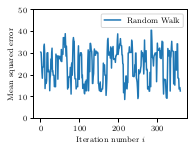

In [152]:
print("Regular MCMC")
print(np.mean(np.array(r[0])))
print(np.median(np.array(r[0])))

print("Squared MCMC")
print(np.mean(np.array(rp[0])))
print(np.median(np.array(rp[0])))

print("Translated MCMC")
print(np.mean(np.array(rt[0])))
print(np.median(np.array(rt[0])))

print("Squared Translated MCMC")
print(np.mean(np.array(rtp[0])))
print(np.median(np.array(rtp[0])))

print("Greedy MCMC")
print(np.mean(np.array(rg[0])))
print(np.median(np.array(rg[0])))

print("RW")
print(np.mean(np.array(rw_l[0])))
print(np.median(np.array(rw_l[0])))

plt.figure(figsize = (2.75, 2.0))
plt.xlabel(r"Iteration number $i$")
plt.ylabel("Mean squared error")

plt.ylim(0, 50)
plt.plot(rw_l[0], label = "Random Walk")
# plt.plot(r[0], label = "Metropolis-Hastings")
# plt.show()

# plt.plot(rp[0], label = "Squared MH")
# plt.show()

# plt.plot(rt[0], label = "Translated MH")
# plt.show()

# plt.plot(rtp[0], label = "Squared Translated MH")
# plt.show()

# plt.plot(rg[0], label = "Greedy MH")
# plt.show()

plt.legend(loc = 1)
plt.savefig('MCMC_Ex2_Plot_RW.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_Ex2_Plot_MCMC.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_AccProb_plot_normal_v3.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_AccProb_plot_squared_v3.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_AccProb_plot_trans_v3.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_AccProb_plot_squared_trans_v3.pgf', bbox_inches = 'tight')
# plt.savefig('MCMC_AccProb_plot_greed_v3.pgf', bbox_inches = 'tight')

plt.show()

In [36]:
print("Metropolis Hastings.")
print(f"MSE incl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_2_list) / len(al_2_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_2_list) + 0))}.")

print(f"Mean MSE:\t{round(sum(l_2_list) / len(l_2_list) + min_likelihood)}.")
print(f"Median MSE:\t{round(np.median(np.array(l_2_list) + min_likelihood))}.")

print(f"MSE excl. non-transitions")
print(f"Mean MSE:\t{round(sum(al_3_list) / len(al_3_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_3_list) + 0))}.")

print(f"MSE incl. rejected transitions")
print(f"Mean MSE:\t{round(sum(al_4_list) / len(al_4_list) + 0)}.")
print(f"Median MSE:\t{round(np.median(np.array(al_4_list) + 0))}.")

# fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(np.array(al_2_list) + 0, label = "Metropolis Hastings")
plt.plot(np.array(l_2_list) + min_likelihood, label = "Metropolis Hastings")
plt.legend(loc = 2)
plt.show()
plt.plot(al_3_list)
plt.show()
plt.plot(al_4_list)

Metropolis Hastings.
MSE incl. non-transitions


NameError: name 'al_2_list' is not defined

In [37]:
print("Random Walk.")
print(f"Mean MSE:\t{round(sum(rw_l_2_list) / len(rw_l_2_list))}.")
print(f"Median MSE:\t{round(np.median(np.array(rw_l_2_list)))}.")


fig = plt.figure(figsize = (3.5, 3))
plt.xlabel("Iteration number")
plt.ylabel("Likelihood")
plt.plot(rw_l_2_list, label = "Random Walk")
plt.legend()

Random Walk.


NameError: name 'rw_l_2_list' is not defined

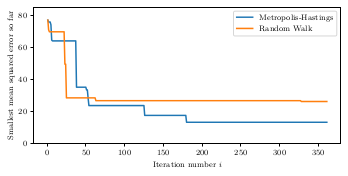

In [22]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

fig = plt.figure(figsize = (5.5, 2.5))
plt.ylim(0, 85)
plt.xlabel(r"Iteration number $i$")
plt.ylabel(r"Smallest mean squared error so far")
plt.plot(range(1, 362), r[1], label = "Metropolis-Hastings")
plt.plot(range(1, 362), rw_l[1], label = "Random Walk")
# plt.plot(range(1, 362), rp[1], label = "Squared MH")
# plt.plot(range(1, 362), rt[1], label = "Translated MH")
# plt.plot(range(1, 362), rtp[1], label = "Squared Translated MH")
# plt.plot(range(1, 362), rg[1], label = "Greedy MH")
plt.legend()
plt.savefig('MCMC_Ex1_plot_v2.pgf', bbox_inches = 'tight')

In [47]:
import itertools

def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0])), total = np.math.factorial(p)):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            
    # return the number of suitable permutations
    return total

get_permutations(U_true)

100%|██████████████████████████████████████████████████████████████████████| 3628800/3628800 [15:02<00:00, 4020.79it/s]


2940

In [45]:
import numpy as np
import itertools
from tqdm import tqdm
def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    perms = []
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0]))):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            perms.append(P)
            
    # return the number of suitable permutations
    return perms, total

P_imp, total_P = get_permutations(W)

3628800it [07:52, 7682.76it/s]


In [56]:
def k_ols_W(Psi, K, P, is_sem = True):
    # translate X
    psi = P @ Psi @ P.T
    k = P @ K @ P.T

    W_hat = np.zeros((p, p))

    # get parameters
    if is_sem:
        for i in range(1, p):
            psi_F = psi[np.array(range(i))[:, None], np.array(range(i))[None, :]]   
            W_hat[np.array(range(i))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i))[:, None], i]
    else: 
        for i in range(p):
            psi_F = psi[np.array(range(i+1))[:, None], np.array(range(i+1))[None, :]]   
            W_hat[np.array(range(i+1))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i+1))[:, None], i]

    return P.T @ W_hat @ P

In [57]:
def loss(W, X, Y):
    return 1 / len(X) * np.linalg.norm(Y - X @ W, 'f') ** 2

In [85]:
Psi = X[:-1].T.dot(X[:-1])
K   = X[:-1].T.dot(X[1:])

P_best = np.identity(p)
W_best = k_ols_W(Psi, K, P_best, is_sem = False)
L_best = loss(W_best, X[:-1], X[1:])

for perm in P_imp:
    perm = np.array(perm.T)
    W_2 = k_ols_W(Psi, K, perm, is_sem = False)
    L = loss(W, X[:-1], X[1:])

    if L < L_best:
        P_best, W_best, L_best = perm, W_2, L

W_U = P_best @ W_best @ P_best.T
W_U[np.abs(W_U) <= 0.25] = 0
print(np.round(P_best @ W_best @ P_best.T, 1))
print(np.round((W_U) != 0, 0))
print(L_best)

[[ 0.5  1.6  1.1  1.7  1.5  1.5 -0.7 -0.5 -1.1 -1.8]
 [ 0.   0.5  1.2  0.  -1.8 -0.1 -1.7 -1.   0.1  1.5]
 [ 0.   0.   0.5 -0.   0.8  0.  -0.9  0.  -0.   1.1]
 [ 0.   0.   0.   0.5  1.2  0.1 -0.9 -0.1 -0.1  0.2]
 [ 0.   0.   0.   0.   0.5 -0.   0.  -1.4  0.  -0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.1 -1.3  1.7  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  1.9 -1.6 -0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5 -0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.8]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
9.741224870151967


In [79]:
print(np.round(P_best @ W @ P_best.T != 0))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [60]:
def con_OLS(X, B):
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

print(W)
print(con_OLS(X, W != 0))
h.score(X, con_OLS(X, W != 0), W)
# help(h.score)

[[ 5.14567573e-01  1.09066141e+00  1.53086420e+00  1.75097591e+00
  -4.31478762e-01 -1.08030736e+00 -1.83356037e+00  1.54391027e+00
   1.50818531e+00 -6.88987986e-01]
 [ 0.00000000e+00  5.20362837e-01  7.90654690e-01  0.00000000e+00
  -7.89788400e-03 -4.51649934e-02  1.12384278e+00  0.00000000e+00
   0.00000000e+00 -9.51471139e-01]
 [ 0.00000000e+00  0.00000000e+00  4.32950029e-01  0.00000000e+00
  -1.42218781e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.82983515e-02  1.23135157e+00  4.53800164e-01
  -1.15555365e-01 -9.42305985e-02  1.03237549e-01  0.00000000e+00
   0.00000000e+00 -8.39556089e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.84836345e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.18728586e-03  0.00000000e+00
  -3.49591480e-02  4.94508704e-01  7.81733525e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00

(1.0, 1.0, 0.0, 1.0, 0, 9.302278158668544, 0.9996891390937035)